本章将使用MNIST数据集，这是一组由美国高中生和人口调查
局员工手写的70000个数字的图片。每张图像都用其代表的数字标
记。这个数据集被广为使用，因此也被称作是机器学习领域的“Hello
World”：


In [1]:
from sklearn.datasets import fetch_mldata
print("sssss")
mnist = fetch_mldata('MNIST Original',data_home='./')
mnist

sssss


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
print(type(mnist))

<class 'sklearn.utils.Bunch'>


Scikit-Learn加载的数据集通常具有类似的字典结构，包括：
·DESCR键，描述数据集
·data键，包含一个数组，每个实例为一行，每个特征为一列
·target键，包含一个带有标记的数组
我们来看看这些数组：


In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


共有7万张图片，每张图片有784个特征。因为图片是28×28像
素，每个特征代表了一个像素点的强度，从0（白色）到255（黑
色）。

先来看看数据集中的一个数字，你只需要随手抓取一个实例的
特征向量，将其重新形成一个28×28数组，然后使用Matplotlib的
imshow（）函数将其显示出来：

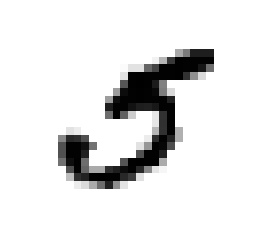

In [60]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

应该先创建一
个测试集，并将其放在一边。事实上MNIST数据集已经分成训练集
（前6万张图像）和测试集（最后1万张图像）了：

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

同样，我们先将训练集数据洗牌，这样能保证交叉验证时所有的
折叠都差不多（你肯定不希望某个折叠丢失一些数字）。此外，有些
机器学习算法对训练实例的顺序敏感，如果连续输入许多相似的实
例，可能导致执行性能不佳。给数据集洗牌正是为了确保这种情况不
会发生

In [5]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

训练一个二元分类器
现在，先简化问题，只尝试识别一个数字——比如数字5。那么
这个“数字5检测器”就是一个二元分类器的例子，它只能区分两个类
别：5和非5。先为此分类任务创建目标向量：

In [57]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

接着挑选一个分类器并开始训练。一个好的初始选择是随机梯度
下降（SGD）分类器，使用Scikit-Learn的SGDClassifier类即可。这个
分类器的优势是，能够有效处理非常大型的数据集。这部分是因为
SGD独立处理训练实例，一次一个（这也使得SGD非常适合在线学
习），稍后我们将会看到。此时先创建一个SGDClassifier并在整个训
练集上进行训练：

In [58]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

SGDClassifier在训练时是完全随机的（因此得名“随机”），如果
你希望得到可复现的结果，需要设置参数random_state。
现在可以用它来检测数字5的图像了：

In [59]:
sgd_clf.predict([some_digit])

array([ True])

性能考核
评估分类器比评估回归器要困难得多，因此本章将用很多篇幅来
讨论这个主题，

使用交叉验证测量精度

相比于cross_val_score（）这一类交叉验证的函数，有时你可能
希望自己能控制得多一些。在这种情况下，你可以自行实施交叉验
证，操作也简单明了。下面这段代码与前面的cross_val_score（）大
致相同，并打印出相同的结果

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

0.9674
0.95695
0.95895


每个折叠由StratifiedKFold执行分层抽样（见第2章）产生，其所
包含的各个类的比例符合整体比例。每个迭代会创建一个分类器的副
本，用训练集对这个副本进行训练，然后用测试集进行预测。最后计
算正确预测的次数，输出正确预测的比率。

现在，用cross_val_score（）函数来评估SGDClassifier模型，采
用K-fold交叉验证法，3个折叠。记住，K-fold交叉验证的意思是将训
练集分解成K个折叠（在本例中，为3折），然后每次留其中1个折叠
进行预测，剩余的折叠用来训练

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

array([0.9674 , 0.95695, 0.95895])

所有折叠交叉验证的准确率（正确预测的比率）超过95%？看起
来挺神奇的，是吗？不过在你开始激动之前，我们来看一个蠢笨的分
类器，它将每张图都分类成“非5”

In [11]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9095 , 0.9093 , 0.91015])

没错，准确率超过90%！这是因为只有大约10%的图像是数字
5，所以如果你猜一张图不是5，90%的时间你都是正确的，简直超越
了大预言家！
这说明准确率通常无法成为分类器的首要性能指标，特别是当你
处理偏斜数据集（skewed dataset）的时候（即某些类比其他类更为频
繁）。

混淆矩阵
评估分类器性能的更好方法是混淆矩阵。总体思路就是统计A类
别实例被分成为B类别的次数。例如，要想知道分类器将数字3和数
字5混淆多少次，只需要通过混淆矩阵的第5行第3列来查看。
要计算混淆矩阵，需要先有一组预测才能将其与实际目标进行比
较。当然可以通过测试集来进行预测，但是现在先不要动它（测试集
最好留到项目最后，准备启动分类器时再使用）。作为替代，可以使
用cross_val_predict（）函数：

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

与cross_val_score（）函数一样，cross_val_predict（）函数同样
执行K-fold交叉验证，但返回的不是评估分数，而是每个折叠的预
测。这意味着对于每个实例都可以得到一个干净的预测（“干净”的意
思是模型预测时使用的数据，在其训练期间从未见过）。
现在，可以使用confusion_matrix（）函数来获取混淆矩阵了。只
需要给出目标类别（y_train_5）和预测类别（y_train_pred）即可：

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53802,   777],
       [ 1557,  3864]], dtype=int64)

一个完美的
分类器只有真正类和真负类，所以它的混淆矩阵只会在其对角线（左
上到右下）上有非零值：

In [15]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

混淆矩阵能提供大量信息，但有时你可能希望指标更简洁一些。
正类预测的准确率是一个有意思的指标，它也称为分类器的精度

精度 = TP / TP + FP
TP是真正类的数量，FP是假正类的数量。
做一个单独的正类预测，并确保它是正确的，就可以得到完美精
度（精度＝1/1＝100%）。但这没什么意义，因为分类器会忽略这个
正类实例之外的所有内容。因此，精度通常与另一个指标一起使用，
这个指标就是召回率（recall），也称为灵敏度（sensitivity）或者真
正类率（TPR）：它是分类器正确检测到的正类实例的比率

召回率 = TP / TP +FN

FN是假负类的数量。


Scikit-Learn提供了计算多种分类器指标的函数，精度和召回率也
是其一：


In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)


0.7127836192584394

因此我们可以很方便地将精度和召回率组合成一个单一的指标，
称为F 1 分数。当你需要一个简单的方法来比较两种分类器时，这是个
非常不错的指标。F 1 分数是精度和召回率的谐波平均值（见公式3-
3）。正常的平均值平等对待所有的值，而谐波平均值会给予较低的
值更高的权重。因此，只有当召回率和精度都很高时，分类器才能得
到较高的F 1 分数

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7680381633870007

F 1 分数对那些具有相近的精度和召回率的分类器更为有利。这不
一定能一直符合你的期望：在某些情况下，你更关心的是精度，而另
一些情况下，你可能真正关心的是召回率。例如，假设你训练一个分
类器来检测儿童可以放心观看的视频，那么你可能更青睐那种拦截了
很多好视频（低召回率），但是保留下来的视频都是安全（高精度）
的分类器，而不是召回率虽高，但是在产品中可能会出现一些非常糟
糕的视频的分类器（这种情况下，你甚至可能会添加一个人工流水线
来检查分类器选出来的视频）。反过来说，如果你训练一个分类器通
过图像监控来检测小偷：你大概可以接受精度只有30%，只要召回率
能达到99%（当然，安保人员会收到一些错误的警报，但是几乎所有
的窃贼都在劫难逃）。
遗憾的是，鱼和熊掌不可兼得：你不能同时增加精度并减少召回
率，反之亦然。这称为精度/召回率权衡

精度/召回率权衡
Scikit-Learn不允许直接设置阈值，但是可以访问它用于预测的决
策分数。不是调用分类器的predict（）方法，而是调用
decision_function（）方法，这个方法返回每个实例的分数，然后就
可以根据这些分数，使用任意阈值进行预测了：

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)

SGDClassifier分类器使用的阈值是0，所以前面的代码返回结果
与predict（）方法一样（也就是True）。我们来试试提升阈值：

In [19]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

这证明了提高阈值确实可以降低召回率。这张图确实是5，当阈
值为0时，分类器可以检测到该图，但是当阈值提高到200000时，就
错过了这张图。
那么要如何决定使用什么阈值呢？首先，使用
cross_val_predict（）函数获取训练集中所有实例的分数，但是这次需
要它返回的是决策分数而不是预测结果：

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

有了这些分数，可以使用precision_recall_curve（）函数来计算
所有可能的阈值的精度和召回率

In [21]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

最后，使用Matplotlib绘制精度和召回率相对于阈值的函数图

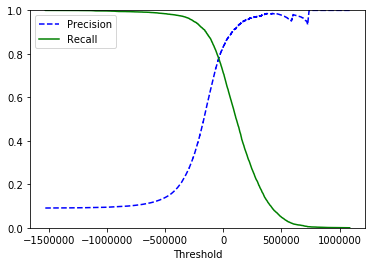

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
        plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
        plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
        plt.xlabel("Threshold")
        plt.legend(loc="upper left")
        plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

你可能会感到好奇，为什么在图3-4中精度曲线比召回率曲线
要崎岖一些？原因在于，当你提高阈值时，精度有时也有可能会下降
（尽管总体趋势是上升的）。要理解原因，可以回头看图3-3，注
意，当把阈值从中间箭头往右移动一位数时：精度从4/5（80%）下
降到3/4（75%）。另一方面，当阈值上升时，召回率只会下降，这
就解释了为什么召回率的曲线看起来很平滑。

现在，就可以通过轻松选择阈值来实现最佳的精度/召回率权衡
了。还有一种找到好的精度/召回率权衡的方法是直接绘制精度和召
回率的函数图，

假设你决定瞄准90%的精度目标。通过绘制的第一张图（放大一
点），得出需要使用的阈值大概是70000。要进行预测（现在是在训
练集上），除了调用分类器的predict（）方法，也可以运行这段代
码

In [23]:
y_train_pred_90 = (y_scores > 70000)

检查一下这些预测结果的精度和召回率：

In [24]:
precision_score(y_train_5, y_train_pred_90)

0.8953058321479375

In [25]:
recall_score(y_train_5, y_train_pred_90)

0.5805201992252352

现在你有一个90%精度的分类器了（或者足够接近）！如你所
见，创建任意一个你想要的精度的分类器是相当容易的事情：只要阈
值足够高即可！然而，如果召回率太低，精度再高，其实也不怎么有
用！

ROC曲线
还有一种经常与二元分类器一起使用的工具，叫作受试者工作特
征曲线（简称ROC）。它与精度/召回率曲线非常相似，但绘制的不
是精度和召回率，而是真正类率（召回率的另一名称）和假正类率
（FPR）。FPR是被错误分为正类的负类实例比率。它等于1减去真负
类率（TNR），后者是被正确分类为负类的负类实例比率，也称为特
异度。因此，ROC曲线绘制的是灵敏度和（1-特异度）的关系。
要绘制ROC曲线，首先需要使用roc_curve（）函数计算多种阈值
的TPR和FPR：

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

然后，使用Matplotlib绘制FPR对TPR的曲线。下面的代码可以绘
制曲线：

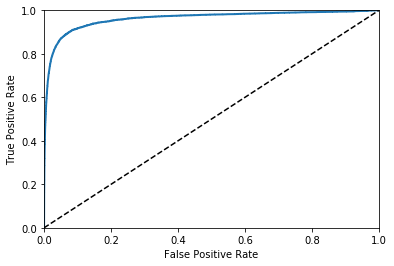

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

同样这里再次面临一个折中权衡：召回率（TPR）越高，分类器
产生的假正类（FPR）就越多。虚线表示纯随机分类器的ROC曲线；
一个优秀的分类器应该离这条线越远越好（向左上角）

有一种比较分类器的方法是测量曲线下面积（AUC）。完美的
分类器的ROC AUC等于1，而纯随机分类器的ROC AUC等于0.5。
Scikit-Learn提供计算ROC AUC的函数：

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9616686475688692

由于ROC曲线与精度/召回率（或PR）曲线非常相似，因此你
可能会问如何决定使用哪种曲线。有一个经验法则是，当正类非常少
见或者你更关注假正类而不是假负类时，你应该选择PR曲线，反之
则是ROC曲线。例如，看前面的ROC曲线图（以及ROC  AUC分
数），你可能会觉得分类器真不错。但这主要是因为跟负类（非5）
相比，正类（数字5）的数量真得很少。相比之下，PR曲线清楚地说
明分类器还有改进的空间（曲线还可以更接近右上角）

训练一个RandomForestClassifier分类器，并比较它和
SGDClassifier分类器的ROC曲线和ROC AUC分数。首先，获取训练
集中每个实例的分数。但是由于它的工作方式不同（参见第7章），
RandomForestClassifier类没有decision_function（）方法，相反，它有
的是dict_proba（）方法。Scikit-Learn的分类器通常都会有这两种方
法的其中一种。dict_proba（）方法会返回一个数组，其中每行为一
个实例，每列代表一个类别，意思是某个给定实例属于某个给定类别
的概率（例如，这张图片有70%的可能是数字5）：

In [29]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

E:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


但是要绘制ROC曲线，需要的是分数值而不是概率大小。一个简
单的解决方案是：直接使用正类的概率作为分数值：

In [30]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

现在可以绘制ROC曲线了。绘制第一条ROC曲线来看看对比结
果

E:\Anaconda\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


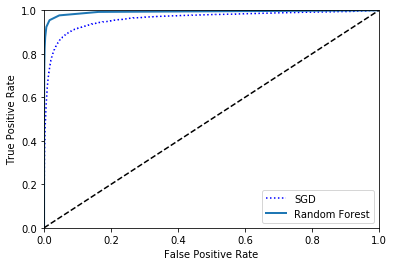

In [31]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

RandomForestClassifier的ROC曲线看起来比
SGDClassifier好很多：它离左上角更接近。因此它的ROC  AUC分数
也高得多：

In [32]:
roc_auc_score(y_train_5, y_scores_forest)

0.9925898652940874

现在你已经掌握了如何训练二元分类器，如何选择合适的指
标利用交叉验证来对分类器进行评估，如何选择满足需求的精度/召
回率权衡，以及如何使用ROC曲线和ROC  AUC分数来比较多个模
型。我们再来试试对数字5之外的检测

多类别分类器
二元分类器在两个类别中区分，而多类别分类器（也称为多项分
类器）可以区分两个以上的类别。
有一些算法（如随机森林分类器或朴素贝叶斯分类器）可以直接
处理多个类别。也有一些严格的二元分类器（如支持向量机分类器或
线性分类器）。但是，有多种策略可以让你用几个二元分类器实现多
类别分类的目的。

例如，要创建一个系统将数字图片分为10类（从0到9），一种方
法是训练10个二元分类器，每个数字一个（0-检测器、1-检测器、2-
检测器，等等，以此类推）。然后，当你需要对一张图片进行检测分
类时，获取每个分类器的决策分数，哪个分类器给分最高，就将其分
为哪个类。这称为一对多（OvA）策略（也称为one-versus-the-
rest）。
另一种方法是，为每一对数字训练一个二元分类器：一个用于区
分0和1，一个区分0和2，一个区分1和2，以此类推。这称为一对一
（OvO）策略。如果存在N个类别，那么这需要训练N×（N-1）÷2个
分类器。对于MNIST问题，这意味着要训练45个二元分类器！当需
要对一张图片进行分类时，你需要运行45个分类器来对图片进行分
类，最后看哪个类别获胜最多。OvO的主要优点在于，每个分类器只
需要用到部分训练集对其必须区分的两个类别进行训练。

Scikit-Learn可以检测到你尝试使用二元分类算法进行多类别分类
任务，它会自动运行OvA（SVM分类器除外，它会使用OvO）。我们
用SGDClassifier试试：

In [33]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([5.])

非常容易！这段代码使用原始目标类别0到9（y_train）在训练集
上对SGDClassifier进行训练，而不是以“5”和“剩余”作为目标类别
（y_train_5）。然后做出预测（在本例中预测正确）。而在内部，
Scikit-Learn实际上训练了10个二元分类器，获得它们对图片的决策分
数，然后选择了分数最高的类别。

想要知道是不是这样，可以调用decision_function（）方法。它
会返回10个分数，每个类别1个，而不再是每个实例返回1个分数：

In [34]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-108648.70998556, -520538.9899199 , -348521.71938753,
        -214904.76441888, -590798.79964771,  218094.40801086,
        -691515.93785182, -348232.0306287 , -743591.72609596,
        -710565.64151197]])

最高分确实是对应数字5这个类别

In [35]:
np.argmax(some_digit_scores)

5

In [36]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [37]:
sgd_clf.classes_[5]

5.0

当训练分类器时，目标类别的列表会存储在classes_这个属
性中，按值的大小排序。在本例里，classes_数组中每个类别的索引
正好对应其类别本身（例如，索引上第5个类别正好是数字5这个类
别），但是一般来说，不会这么恰巧。

如果想要强制Scikit-Learn使用一对一或者一对多策略，可以使用
OneVsOne Classifier或OneVsRestClassifier类。只需要创建一个实例，
然后将二元分类器传给其构造函数。例如，下面这段代码使用OvO策
略，基于SGDClassifier创建了一个多类别分类器：

In [38]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

array([5.])

In [39]:
len(ovo_clf.estimators_)

45

训练RandomForestClassifier同样简单

In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

这次Scikit-Learn不必运行OvA或者OvO了，因为随机森林分类器
直接就可以将实例分为多个类别。调用predict_proba（）可以获得分
类器将每个实例分类为每个类别的概率列表：

In [41]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0.1, 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

array([0.86212757, 0.86064303, 0.88023203])

在所有的测试折叠上都超过了84%。如果是一个纯随机分类器，
准确率大概是10%，所以这个结果不是太糟，但是依然有提升的空
间。例如，将输入进行简单缩放（如第2章所述）可以将准确率提到
90%以上：

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

array([0.90946811, 0.90979549, 0.91038656])

错误分析
当然，如果这是一个真正的项目，你将遵循机器学习项目清单中
的步骤（见附录B）：探索数据准备的选项，尝试多个模型，列出最
佳模型并用GridSearchCV对其超参数进行微调，尽可能自动化，等
等。正如你在之前的章节里尝试的那些。在这里，假设你已经找到了
一个有潜力的模型，现在你希望找到一些方法对其进一步改进。方法
之一就是分析其错误类型。


首先，看看混淆矩阵。就像之前做的，使用cross_val_predict（）
函数进行预测，然后调用confusion_matrix（）函数：

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

array([[5731,    2,   22,   10,   10,   50,   44,    9,   41,    4],
       [   1, 6500,   40,   27,    6,   45,    5,    9,   97,   12],
       [  61,   39, 5311,  102,   81,   22,   96,   61,  171,   14],
       [  47,   44,  126, 5338,    4,  246,   36,   53,  136,  101],
       [  19,   26,   36,    5, 5354,   10,   50,   31,   90,  221],
       [  73,   42,   35,  168,   78, 4592,  114,   29,  198,   92],
       [  34,   27,   46,    2,   41,   88, 5621,    7,   52,    0],
       [  26,   22,   69,   28,   55,    9,    5, 5802,   14,  235],
       [  57,  163,   67,  142,   14,  156,   55,   27, 5026,  144],
       [  44,   29,   28,   85,  150,   36,    3,  185,   71, 5318]],
      dtype=int64)

数字有点多，使用Matplotlib的matshow（）函数来查看混淆矩阵
的图像表示，通常更加方便：

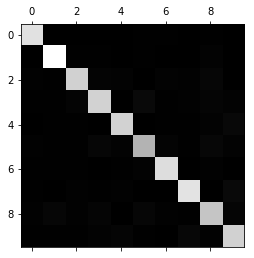

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

混淆矩阵看起来很不错，因为大多数图片都在主对角线上，这说
明它们被正确分类。数字5看起来比其他数字稍稍暗一些，这可能意
味着数据集中数字5的图片较少，也可能是分类器在数字5上的执行效
果不如在其他数字上好。实际上，你可能会验证这两者都属实

让我们把焦点放在错误上。首先，你需要将混淆矩阵中的每个值
除以相应类别中的图片数量，这样你比较的就是错误率而不是错误的
绝对值（后者对图片数量较多的类别不公平）：

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

用0填充对角线，只保留错误，重新绘制结果：

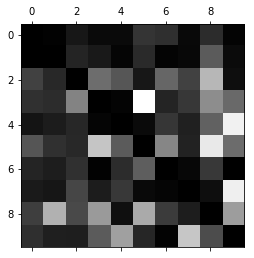

In [49]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

现在可以清晰地看到分类器产生的错误种类了。记住，每行代表
实际类别，而每列表示预测类别。第8列和第9列整体看起来非常亮，
说明有许多图片被错误地分类为数字8或数字9了。同样，类别8和类
别9的行看起来也偏亮，说明数字8和数字9经常会跟其他数字混淆。
相反，一些行很暗，比如行1，这意味着大多数数字1都被正确地分类
（有一些与数字8弄混，但仅此而已）。注意，错误不是完全对称
的，比如，数字5被错误分类为数字8的数量比数字8被错误分类为数
字5的数量要更多。

分析混淆矩阵通常可以帮助你深入了解如何改进分类器。通过上
面那张图来看，你的精力可以花在改进数字8和数字9的分类，以及修
正数字3和数字5的混淆上。例如，可以试着收集更多这些数字的训练
数据。或者，也可以开发一些新特征来改进分类器——举个例子，写
一个算法来计算闭环的数量（例如，数字8有两个，数字6有一个，数
字5没有）。再或者，还可以对图片进行预处理（例如，使用Scikit-
Image、Pillow或OpenCV）让某些模式更为突出，比如闭环之类的。

分析单个的错误也可以为分类器提供洞察：它在做什么？它为什
么失败？但这通常更加困难和耗时。例如，我们来看看数字3和数字5
的例子：


In [50]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

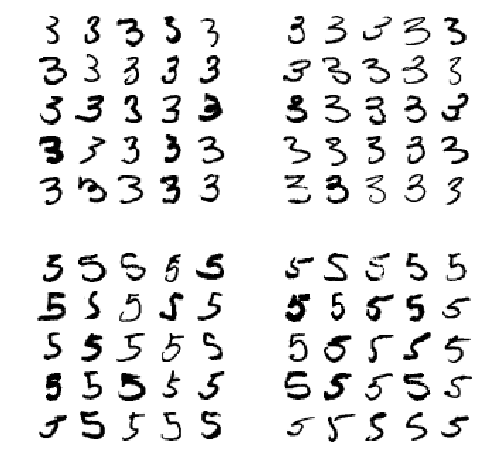

In [51]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

左侧的两个5×5矩阵显示了被分类为数字3的图片，右侧的两个
5×5矩阵显示了被分类为数字5的图片。分类器弄错的数字（即左下方
和右上方的矩阵）里，确实有一些写得非常糟糕，即便是人类也很难
做出区分（例如，第8行第1列的数字5看起来真的很像数字3）。然
而，对我们来说，大多数错误分类的图片看起来还是非常明显的错
误，我们很难理解分类器为什么会弄错。 [1] 原因在于，我们使用的简
单的SGDClassifier模型是一个线性模型。它所做的就是为每个像素分
配一个各个类别的权重，当它看到新的图像时，将加权后的像素强度
汇总，从而得到一个分数进行分类。而数字3和数字5只在一部分像素
位上有区别，所以分类器很容易将其弄混。

数字3和数字5之间的主要区别是在于连接顶线和下方弧线的中间
那段小线条的位置。如果你写的数字3将连接点略往左移，分类器就
可能将其分类为数字5，反之亦然。换言之，这个分类器对图像移位
和旋转非常敏感。因此，减少数字3和数字5混淆的方法之一，就是对
图片进行预处理，确保它们位于中心位置并且没有旋转。这也同样有
助于减少其他错误。
[1] 但是记住，我们的大脑是一个非常神奇的模式识别系统，在信息
传达到我们的意识之前，视觉系统会对其进行大量的复杂的预处理，
所以任何看起来很简单的事情并不意味着它真的简单。

多标签分类

In [52]:
到目前为止，每个实例都只会被分在一个类别里。而在某些情况
下，你希望分类器为每个实例产出多个类别。例如，人脸识别的分类
器：如果在一张照片里识别出多个人怎么办？当然，应该为识别出来
的每个人都附上一个标签。假设分类器经过训练，已经可以识别出三
张脸——爱丽丝、鲍勃和查理，那么当看到一张爱丽丝和查理的照片
时，它应该输出[1，0，1]（意思是“是爱丽丝，不是鲍勃，是查理”）
这种输出多个二元标签的分类系统称为多标签分类系统

SyntaxError: invalid character in identifier (<ipython-input-52-f3b2b03ac954>, line 2)

为了阐释清楚，这里不讨论面部识别，让我们来看一个更为简单
的例子：

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

这段代码会创建一个y_multilabel数组，其中包含两个数字图片的
目标标签：第一个表示数字是否是大数（7、8、9），第二个表示是
否为奇数。下一行创建一个KNeighborsClassifier实例（它支持多标签
分类，不是所有的分类器都支持），然后使用多个目标数组对它进行
训练。现在用它做一个预测，注意它输出的两个标签：

In [ ]:
knn_clf.predict([some_digit])

结果是正确的！数字5确实不大（False），为奇数（True）。
评估多标签分类器的方法很多，如何选择正确的度量指标取决于
你的项目。比如方法之一是测量每个标签的F 1 分数（或者是之前讨论
过的任何其他二元分类器指标），然后简单地平均。下面这段代码计
算所有标签的平均F 1 分数：

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

这里假设了所有的标签都同等重要，但实际可能不是这样。特别
是，如果训练的照片里爱丽丝比鲍勃和查理要多很多，你可能想给区
分爱丽丝的分类器更高的权重。一个简单的办法是给每个标签设置一
个等于其自身支持的权重（也就是具有该目标标签的实例的数量）。
只需要在上面的代码中设置average="weighted"即可。 [1]
[1] Scikit-Learn还提供了一些其他计算平均的方法，以及其他的多标
签分类器指标，相关详细信息请参阅文档。




